In [2]:
%load_ext autoreload
%autoreload 2
from utility import *
client = Client(scheduler_file="/home/bzr0014/schedfile")
client.restart()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [3]:
files = glob.glob("/nfs_shares/bzr0014_home/additive_data/experiment_04/*3D.df")
databases = [delayed(lambda x: joblib.load(x).assign(file=x))(f) for f in files]

In [23]:
def get_cols(df, names):
    if isinstance(names, str):
        cols = [x for x in df.columns if names in x]
    else:
        cols = list({x for name in names for x in df.columns if name in x})
    return df[cols]
def get_file_info(res):
    a = res.str.lower().str.contains('polished').rename('ispolished').to_frame()
    b = pd.DataFrame(res.map(lambda x: re.findall(f"(v\d+)_(t\d+)_(l|r)", x, re.IGNORECASE)[0]).tolist(),
                columns=['specimen', 'T', 'RL'], index=a.index)
    return a.join(b)#.join(res.str.rsplit('/', n=1, expand=True)[1])

In [29]:
def get_rho10(df, file_name):
    x = df.copy()
    x.columns = ['_'.join([t for t in c if len(t)]) for c in x.columns]
    mid_section_x = x[(x['profile']>1000) & (x['profile']<6000)]

    mid_section_xy = mid_section_x[(mid_section_x['circle_sym_x']>1000)&(mid_section_x['circle_sym_x']<7000)]
    mid_section_xy = get_cols(mid_section_xy, ["profile", "circle_"])
    mid_section_xy.circle_sym_y = mid_section_xy.circle_sym_y.astype('int')
    mid_section_xy.profile = mid_section_xy.profile.astype('int')

    y_sym = mid_section_xy.groupby("profile").circle_sym_y.agg(lambda x: sorted(x)[:10]).explode().astype('int').to_frame().reset_index()
    rho10 = y_sym.merge(mid_section_xy[['profile', 'circle_sym_y', 'circle_sym_r', 'circle_asym_r']], on=['profile', 'circle_sym_y'])
    out = rho10.assign(file=file_name)
    return get_file_info(out['file']).join(out).drop('file', axis=1)

In [30]:
rho10s = [delayed(get_rho10)(x, f) for x, f in zip(databases, files)]

In [31]:
rho10s = compute(rho10s)[0]

In [32]:
Rhos = pd.concat(rho10s)

In [61]:
tmp = (Rhos.groupby('specimen').ispolished.nunique() > 1)\
    .to_frame().reset_index()#.drop('ispolished', axis=1)
polished_specimens = tmp[tmp.ispolished].drop('ispolished', axis=1)

In [453]:
out = Rhos.merge(polished_specimens, on='specimen').groupby(['specimen', 'ispolished']).describe()

In [454]:
out[['circle_sym_r', 'circle_asym_r']]

circle_sym_r                                          \
                           count      mean       std       min       25%   
specimen ispolished                                                        
V03      False          335159.0  1.643829  1.531761  0.105655  0.513020   
         True           369480.0  2.060226  1.965475  0.448857  0.506373   
V05      False          324990.0  1.903803  1.687877  0.063407  0.516987   
         True           392156.0  1.971351  1.929412  0.431861  0.507589   
V07      False          282945.0  2.349671  2.261558  0.096374  0.525389   
         True           389740.0  2.182084  2.025143 -1.276439  0.515654   
V09      False          343784.0  2.103695  2.001008  0.021706  0.520757   
         True           375044.0  2.001891  1.943115  0.439062  0.506010   
V11      False          349485.0  2.216336  2.088190  0.088808  0.520923   
         True           373057.0  1.983865  1.933841  0.448085  0.506321   
V13      False          147678.0  1.779475  1.724185  0.071259  0.514583   
         True           345217.0  2.347177  2.259041  0.242071  0.513284   
V15      False          150297.0  2.061549  1.709324 -1.889589  0.532137   
         True           270911.0  2.435544  2.493725  0.456077  0.515491   
V17      False          245004.0  2.031748  1.801572  0.049129  0.515919   
         True           364600.0  2.383676  2.236157  0.085380  0.518284   

                                                   circle_asym_r            \
                          50%       75%        max         count      mean   
specimen ispolished                                                          
V03      False       0.988292  2.355612  58.883036      335159.0  2.760970   
         True        1.444469  3.038256  21.489499      369480.0  3.368880   
V05      False       1.299172  2.792407  22.544196      324990.0  3.295630   
         True        1.275951  2.756426  21.520883      392156.0  3.095746   
V07      False       1.614936  3.508708  32.740698      282945.0  4.011948   
         True        1.517327  3.330599  23.689824      389740.0  3.479037   
V09      False       1.499404  3.026305  61.198172      343784.0  3.814517   
         True        1.241175  2.926302  22.690155      375044.0  3.244136   
V11      False       1.533724  3.272566  46.056770      349485.0  4.020237   
         True        1.267109  2.841902  21.515283      373057.0  3.154461   
V13      False       1.137422  2.515137  50.206865      147678.0  3.350284   
         True        1.574854  3.512137  25.575007      345217.0  4.002930   
V15      False       1.682280  2.946195  45.126751      150297.0  3.634414   
         True        1.549957  3.520888  27.314725      270911.0  4.105484   
V17      False       1.501365  2.969011  30.732468      245004.0  3.658514   
         True        1.676159  3.525679  24.878452      364600.0  3.958283   

                                                                        \
                          std        min       25%       50%       75%   
specimen ispolished                                                      
V03      False       2.080429   0.003813  1.215652  2.340237  3.837734   
         True        2.442443   0.002135  1.627272  2.884301  4.484249   
V05      False       2.138469  -2.026938  1.698911  2.974625  4.501813   
         True        2.330758   0.002011  1.437801  2.599030  4.110108   
V07      False       2.758997   0.004190  2.041081  3.531087  5.506305   
         True        2.424657  -0.523295  1.697840  3.063015  4.705226   
V09      False       2.708930 -13.232230  1.963413  3.378057  5.074145   
         True        2.356806   0.002371  1.546603  2.765754  4.350814   
V11      False       2.762773   0.004681  2.081121  3.569836  5.465409   
         True        2.314037   0.001040  1.500780  2.691909  4.166209   
V13      False       2.639175  -3.024847  1.539249  2.854761  4.510796   
         True        2.933773   0.001084  1.994055  3.48

In [66]:
out[['circle_sym_r', 'circle_asym_r']]

circle_sym_r  circle_asym_r
specimen ispolished                             
V03      False           1.643829       2.760970
         True            2.060226       3.368880
V05      False           1.903803       3.295630
         True            1.971351       3.095746
V07      False           2.349671       4.011948
         True            2.182084       3.479037
V09      False           2.103695       3.814517
         True            2.001891       3.244136
V11      False           2.216336       4.020237
         True            1.983865       3.154461
V13      False           1.779475       3.350284
         True            2.347177       4.002930
V15      False           2.061549       3.634414
         True            2.435544       4.105484
V17      False           2.031748       3.658514
         True            2.383676       3.958283

In [448]:
out

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [80]:
from features import *
x = joblib.load("/nfs_shares/bzr0014_home/additive_data/experiment_03/V07_T1_Right(Top)_500X_3D.info")['value'].x
y = joblib.load("/nfs_shares/bzr0014_home/additive_data/experiment_03/Polished_V07_T1_Right(Top)_500X_3D.info")['value'].x

In [81]:
x = np.array(x)
y = np.array(y)

In [82]:
x.mean() -  y.mean()

-11.63945

In [83]:
x.std(), y.std()

(40.681553, 44.58649)

In [73]:
df = pd.read_csv('global_1d_parameters.csv')

In [76]:
df[df['specimen']=='v07']

,Unnamed: 0,specimen,T,RL,ispolished,ra,rq,r10_iso,rv,rz
36,36,v07,t1,l,False,16.303761,19.963918,34.841801,61.243527,67.608119
37,37,v07,t1,l,True,10.619034,12.583137,25.200190,20.362228,44.212130
38,38,v07,t1,r,False,17.431765,21.366078,37.518191,63.585311,72.821200
39,39,v07,t1,r,True,12.717365,15.109074,30.395898,25.155199,56.720327
40,40,v07,t2,l,False,17.790403,22.006267,37.615698,66.465101,73.570684
41,41,v07,t2,l,True,13.049757,16.134469,33.585491,36.927890,52.952555
42,42,v07,t2,r,True,11.687957,13.826566,27.602397,22.934161,48.980018


In [271]:
x = joblib.load(f"/nfs_shares/bzr0014_home/additive_data/experiment_03/{base_name}.info")['value'].x

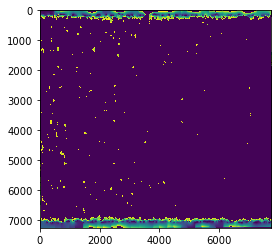

distributed.client - ERROR - Failed to reconnect to scheduler after 3.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [273]:
plt.imshow(x*(x<x.mean()-1*x.std()))

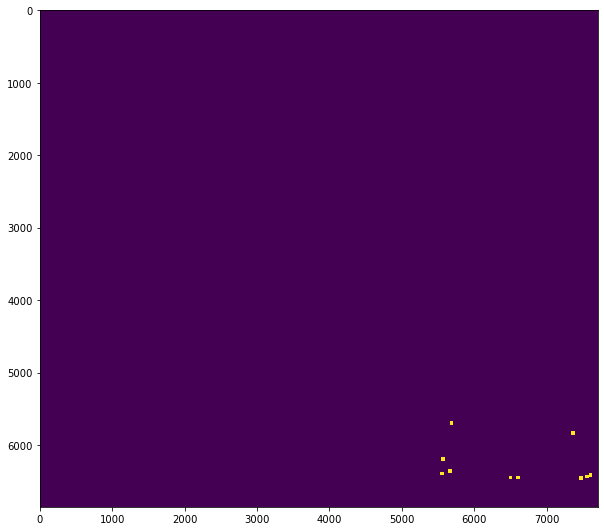

In [278]:
fig, ax = plt.subplots(figsize=(10, 10))
base_name = "V12_T1_Right(Top)_500X_3D"
img = cv2.imread(f"/nfs_shares/bzr0014_home/additive_data/local_minima/{base_name}.png", 0)
plt.imshow(img)

In [252]:
x = joblib.load(f"/nfs_shares/bzr0014_home/additive_data/experiment_04/{base_name}.df")

In [253]:
x.columns = ['_'.join([t for t in c if len(t)]) for c in x.columns]

In [257]:
mid_section_x = x[(x['profile']>200) & (x['profile']<6500)]
mid_section_xy = mid_section_x[(mid_section_x['circle_sym_x']>200)&(mid_section_x['circle_sym_x']<7500)]

In [258]:
tmp = mid_section_xy[['profile', 'circle_asym_x', 'circle_asym_y', 'circle_asym_r']]
z = tmp.assign(mult=tmp['circle_asym_y']*np.log(tmp['circle_asym_r']+1), profile=tmp['profile'].astype('int'),
        circle_asym_y=tmp['circle_asym_y'].astype('int'),
        circle_asym_x=tmp['circle_asym_x'].astype('int')).sort_values('mult')[:100]
z

,profile,circle_asym_x,circle_asym_y,circle_asym_r,mult
602024,5976,6215,134,-0.602303,-124.237384
143,11,391,0,30.499918,-3.378449
161,12,391,0,30.499738,-3.287845
181,13,391,0,30.498954,-3.115649
202,14,391,0,30.496472,-2.821651
...,...,...,...,...,...
709189,7178,1379,7,0.008974,0.071444
705280,7064,5668,6,0.011910,0.073223
709172,7177,1379,8,0.009273,0.073937
703016,7038,936,1,0.045328,0.074126


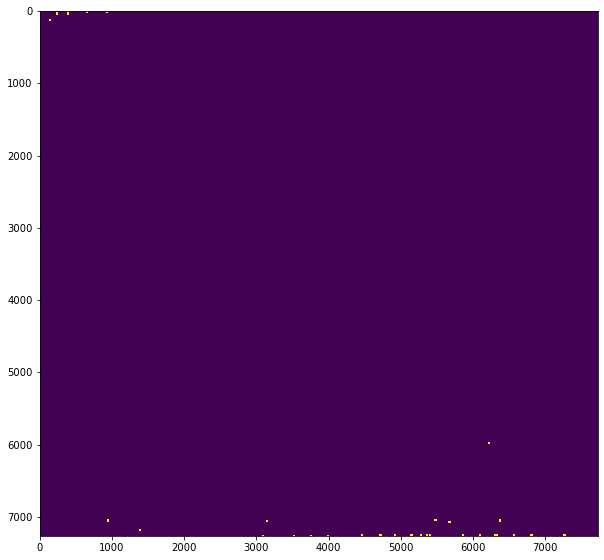

In [274]:
fig, ax = plt.subplots(figsize=(10, 10))
out = np.zeros_like(img)
out[(z['profile'].values, z['circle_asym_x'].values)] = 1
out = cv2.dilate(out, np.ones((30, 30)))
plt.imshow(out)

In [222]:
f = cv2.imread("Screen Shot 2020-06-10 at 3.08.56 PM.png")

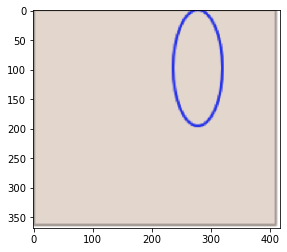

In [223]:
plt.imshow(f)

In [423]:
base_name = "Polished_V11_T1_Right(Top)_500X_3D"
y = joblib.load(f"/nfs_shares/bzr0014_home/additive_data/experiment_03/{base_name}.info")['value'].x
base_name = "V11_T1_Right(Top)_500X_3D"
x = joblib.load(f"/nfs_shares/bzr0014_home/additive_data/experiment_03/{base_name}.info")['value'].x

In [435]:
t = x[1500:-1500, 1500:-1500]#x[3000:-3000, 3000:-3000]

In [436]:
indices = np.random.randint(len(t), size=90)
mean = np.array([t[i].mean() for i in indices])
mn = np.array([t[i].min() for i in indices])
(mean - mn).mean()

52.89042367037844

In [437]:
#t = y[3000:-3000, 3000:-3000]
t = y[1500:-1500, 1500:-1500]#x[3000:-3000, 3000:-3000]

In [438]:
indices = np.random.randint(len(t), size=90)
mean = np.array([t[i].mean() for i in indices])
mn = np.array([t[i].min() for i in indices])
(mean - mn).mean()

29.638622017362504

In [439]:
from scipy.stats import mode

In [442]:
t = x#[1500:-1500, 1500:-1500]#x[3000:-3000, 3000:-3000]
mode((t-t.mean()).astype('int').reshape(-1))

ModeResult(mode=array([0]), count=array([1326504]))

In [443]:
t = y#[1500:-1500, 1500:-1500]#x[3000:-3000, 3000:-3000]
mode((t-t.mean()).astype('int').reshape(-1))

ModeResult(mode=array([16]), count=array([3499035]))

In [417]:
np.median(x-x.mean())

0.7370071411132812

In [418]:
np.median(y-y.mean())

7.5929412841796875

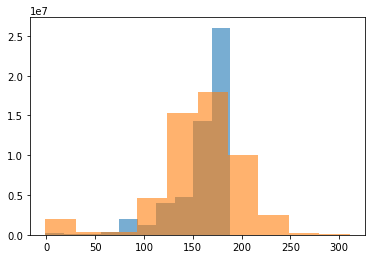

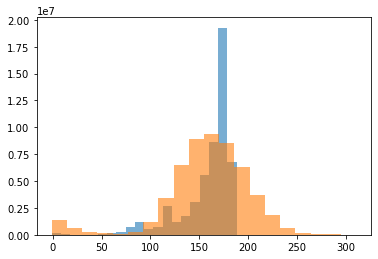

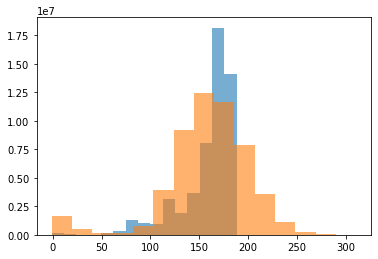

In [460]:
for bins in {10, 15, 20}:
    plt.hist(np.array(y.reshape(-1)), alpha=.6, bins=bins)
    plt.hist(np.array(x.reshape(-1)), alpha=.6, bins=bins)
    plt.show()